In [20]:
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst, wf_from_files, WfType
from invisible_cities.core.core_functions import in_range
from invisible_cities.database  import load_db
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from scipy.signal import find_peaks
from scipy.signal import wiener
from scipy.signal import butter, filtfilt
from pathlib  import Path
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import sys
from datetime import datetime


In [21]:
def find_highest_wf(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    wfs[16] = np.arange(wfs[16] .size) * 0
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return wfs[index]

def find_highest_sipm(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]
    index = np.argmax(np.max(wfs, axis=1))
    print(index)
    return index

In [22]:
def sum_wf1(wfs, event_number):
    assert len(wfs.shape) == 3, "input must be 3-dimensional"

    wfs   = wfs[event_number]

    element_wise_sum = np.zeros_like(wfs[0],dtype=np.int64)

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def sum_wf(wfs):
    element_wise_sum = np.zeros_like(wfs[0])

    # Sum the arrays element-wise
    for array in wfs:
        element_wise_sum += array

    return element_wise_sum

def ADC_to_PE(wfs, datapmt):
    conv_factors = datapmt.adc_to_pes.to_numpy()

    for w in range(0, len(wfs)):
        if (conv_factors[w] == 1e5):
            conv_factors[w] = 0
        wfs[w] = wfs[w]*conv_factors[w]

    return wfs


def check_summed_baseline(wfs_sum, grass_lim, scale_factor):

    flag=False
    tc=25e-3
    
    # Check the baseline at the end and start match
    # otherwise there could be signal there so the baseline is all messed up
    num_samples = int(25/tc)
    baseline1=np.mean(wfs_sum[-num_samples:])
    baseline2=np.mean(wfs_sum[0:int(25/tc)])

    # 20 seems like a good number to check the difference against
    if (abs(baseline1-baseline2) > 20*scale_factor):
        print("Error in baselines at start and end, dropping event")
        print(baseline1-baseline2)
        flag = True

    # Look in the window for large peaks that could be other S2 pulses. 
    # This will mess up the reconstruction
    peaks, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=2000, distance=30/tc)

    # print(peaks*tc)

    # print(wfs_sum[int(peaks[0] + grass_lim[0]/tc - 5/tc) : int(peaks[0] + grass_lim[0]/tc + 5/tc)].sum())

    peaks_filt = np.array([
        p for p in peaks
        if wfs_sum[int(p + grass_lim[0]/tc - 5/tc) : int(p + grass_lim[0]/tc + 5/tc)].sum() > 1e6
    ])

    return flag, peaks_filt

def get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim):

    df = []

    tsel_     = in_range(times, *grass_lim)
    wfs = wfs[:, tsel_]

    for pmt_no, wf in enumerate(wfs):

        idx_over_thr = np.argwhere(wf > noise[pmt_no]).flatten()
        splits       = np.argwhere(np.diff(idx_over_thr) > thr_split).flatten()
        idx_slices   = np.split(idx_over_thr, splits+1)
        idx_slices   = list(filter(lambda sl: in_range(len(sl), peak_minlen, peak_maxlen + .5), idx_slices))

        for sl in idx_slices:
            m = np.argmax(wf[sl]) + sl[0]
            pe_int = wf[m-half_window:m+half_window].sum()*tc
            df.append(pd.DataFrame(dict(event = evt_info[evt_no][0], ts_raw=ts/1e3, pmt=pmt_no, pe_int=pe_int, peak_time=m*tc+grass_lim[0], noise_thr=noise[pmt_no]), index=[0]))

    return df


def CorrectRawBaseline(wfs):

    corrected_waveforms = []

    for wfm in wfs:
        num_samples = int(25/tc)
        baseline1=np.mean(wfm[-num_samples:])
        baseline2=np.mean(wfm[0:int(25/tc)])
        wfm = -1*(wfm-baseline2)
        corrected_waveforms.append(wfm)

    return np.array(corrected_waveforms)


def find_fwhm(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    # First crossing point
    left_idx = above_half_max[0]
    right_idx = above_half_max[-1]

    # Interpolate to get more accurate crossing times
    t_left = np.interp(half_max, [amplitude[left_idx-1], amplitude[left_idx]], [time[left_idx-1], time[left_idx]])
    t_right = np.interp(half_max, [amplitude[right_idx], amplitude[right_idx+1]], [time[right_idx], time[right_idx+1]])

    fwhm = t_right - t_left
    return fwhm, max_amplitude


# Get interpolation of the background noise just after the S2
def GetBaselineInterp(noise, wfs, t_pmt):

    interps = []
    for pmt_no, wf in enumerate(wfs):
        threshold = noise[pmt_no]

        # Select points where amplitude is below the threshold
        mask = (wf < threshold) & (wf > -threshold)
        filtered_time = t_pmt[mask]
        filtered_amplitude = wf[mask]

        if (len(filtered_amplitude) == 0):
            filtered_time = t_pmt
            filtered_amplitude = np.zeros(len(t_pmt))
        
        # Generate smooth line over the full time range
        smoothed_amplitude = savgol_filter(filtered_amplitude, 301, 1)

        # Interpolate the smoothed data
        interp_func = interp1d(filtered_time, smoothed_amplitude, kind='cubic', bounds_error=False, fill_value=0)  # Cubic interpolation for smoothness
        interps.append(interp_func)

    return interps


# Uses the interpolation in a range to fix the baseline
def CorrectDeconvBaseline(t_pmt, tmin, tmax, interps, wfs):
    
    for pmt_no, wf in enumerate(wfs):
        # Apply the interpolation function to waveform time points
        amplitude_interpolated = interps[pmt_no](t_pmt)
        mask = (t_pmt < tmin) | (t_pmt > tmax)
        amplitude_interpolated[mask] = 0

        # Subtract the interpolated amplitude from the waveform amplitude
        wfs[pmt_no] = wf - amplitude_interpolated

    return wfs

# Fit the distribution 
def Gaussian(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

def FitS2(time, amplitude):
    max_amplitude = np.max(amplitude)
    half_max = max_amplitude / 2

    # Find indices where amplitude crosses half-maximum level
    above_half_max = np.where(amplitude >= half_max)[0]

    time_slice = time[above_half_max]
    # print(time_slice)
    

    # Perform the curve fit
    params, covariance = curve_fit(Gaussian, time[above_half_max], amplitude[above_half_max], bounds = ([1e3, min(time_slice),1], [8.5e8, max(time_slice),50]))

    # Extract the fitted parameters
    A, mu, sigma = params
    print(A, mu, sigma )

    return A, mu, sigma


In [29]:
# filename  = "../data/run_13852_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/run_13859_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/run_14180_0049_ldc6_trg0.waveforms.h5" 
# filename  = "../data/run_14584_0000_ldc1_trg0.waveforms.h5"
# filename  = "../data/xenon/run_14498_0011_ldc3_trg0.waveforms.h5"
# filename = "../data/run_14583_0000_ldc1_trg0.waveforms.h5"
filename = "../data/run_14710_0000_ldc7_trg0.waveforms.h5"

raw_evts = pd.read_hdf(filename, '/Run/events')
print(raw_evts.evt_number.unique())

raw_evts = load_dst(filename, 'Run', 'events')
nrwfs = len(raw_evts.evt_number.unique())
print("Number of Waveforms:", nrwfs)


[  6  13  20  27  34  41  48  55  62  69  76  83  90  97 104 111 118 125
 132 139 146 153 160 167 174 181 188 195 202 209 216 223 230 237 244 251
 258 265 272 279 286 293 300 307 314 321 328 335 342 349 356]
Number of Waveforms: 51


In [37]:
# Load in the database for SiPMs

# RUN_NUMBER = 13852
# RUN_NUMBER=13859
# RUN_NUMBER = 14180
# RUN_NUMBER = 14498
# RUN_NUMBER = 14584
# RUN_NUMBER = 14583
RUN_NUMBER = 14710

deconv = deconv_pmt("next100", RUN_NUMBER, 62400)

detector_db = "next100"
datasipm = load_db.DataSiPM(detector_db, RUN_NUMBER)
datapmt = load_db.DataPMT(detector_db, RUN_NUMBER)

datasipm_correct = load_db.DataSiPM(detector_db, 14450)
datasipm_correct = datasipm_correct[["SensorID", "ChannelID", "X", "Y"]]
datasipm = datasipm[["SensorID", "ChannelID", "X", "Y"]]

data_sipm_merge  = pd.merge(datasipm, datasipm_correct, on='SensorID', how='inner')

display(datasipm)
# display(datasipm_correct)

# display(data_sipm_merge[ (data_sipm_merge['X_x'] != data_sipm_merge['X_y'] ) | (data_sipm_merge['Y_x'] != data_sipm_merge['Y_y'] )])

# display(datapmt)

thr_split   = 2      # maximum number of samples allowed to be below threshold to consider it a peak
peak_minlen = 2      # minimum number of samples above threshold in a peak
peak_maxlen = 10     # maximum number of samples above threshold in a peak
half_window = 4      # number of samples to each side of a peak maximum to integrate
tc          = 25e-3  # constant to convert from samples to time or vice versa. 
noise_sigma = 4      # how many STD above noise for the single PEs to be
scale_factor = 40*60 # Scale factor for summed waveform. 60 Pmts, 40 is ~ the conversion factor

dead_pmts = [3, 16, 24, 36, 37, 38, 39,40, 41, 48, 53, 58]

if (RUN_NUMBER == 13850 or RUN_NUMBER == 13852 or RUN_NUMBER == 13859):
    grass_lim   = 1050, 1770 # time window in mus in which to search for single pes
    noise_lim   = 1900, 2000 # time window to calculate the noise baseline
    S1_height   = 10000
    S2_height   = 50000
    S2_start    = 990        # S2 integration window start
    S2_end      = 1040       # S2 integration window end
    cath_lim    = 1785, 1860 # start/end window for cathode events
    S1_window   = 100, 985   # window to search for S1
    S2_window   = 985, 1200  # window to search for S2

elif (RUN_NUMBER == 14180):
    grass_lim   = 1050, 1770 
    noise_lim   = 1900, 2000 
    S1_height   = 10000
    S2_height   = 50000
    S2_start    = 990
    S2_end      = 1040
    cath_lim    = 1785, 1860 
    S1_window   = 100, 985
    S2_window   = 985, 1200 

elif (RUN_NUMBER == 14498):
    grass_lim   = 1650, 2350
    noise_lim   = 2500, 2600
    S1_height   = 20000
    S2_height   = 50000
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 2500, 2550 
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 

elif (RUN_NUMBER == 14584 or RUN_NUMBER == 14583): # 20 kV
    grass_lim   = 1650, 2350
    noise_lim   = 3100, 3200
    S1_height   = 20000
    S2_height   = 50000
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 3014, 3064
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 

elif (RUN_NUMBER == 14710): # 20 kV
    grass_lim   = 1050, 1770
    noise_lim   = 3100, 3200
    S1_height   = 20000
    S2_height   = 50000
    S2_start    = 1590
    S2_end      = 1640
    cath_lim    = 3014, 3064
    S1_window   = 100, 1585
    S2_window   = 1585, 1800 


else:
    print("Unknown RUN Configured")


useRaw = False



,SensorID,ChannelID,X,Y
0,1000,56013,-482.625,-294.825
1,1001,56012,-482.625,-279.275
2,1002,56015,-482.625,-263.725
3,1003,56014,-482.625,-248.175
4,1004,56029,-482.625,-232.625
...,...,...,...,...
3579,56059,14054,490.025,245.425
3580,56060,14037,490.025,260.975
3581,56061,14036,490.025,276.525
3582,56062,14039,490.025,292.075


On Event: 0
On Event: 1
On Event: 2
On Event: 3
2977
319.975 -155.875
1000.0000000000001 1608.9180517220425 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -167.65627369714412
On Event: 4
2977
319.975 -155.875


/Users/mistryk2/opt/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1000.0000000000001 1625.05 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -190.73657955555382
On Event: 5
2977
319.975 -155.875
1000.0000000000001 1619.4557599327889 1.0000000000000002
Area under the Gaussian: 2506.63
0
On Event: 6
On Event: 7
2977
319.975 -155.875
1000.0000000000001 1618.4574029107446 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -187.04259466034924
On Event: 8
On Event: 9
2977
319.975 -155.875


/Users/mistryk2/opt/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1021.8673148876414 1627.9219146999644 1.000000000000001
Area under the Gaussian: 2561.44
0
On Event: 10
On Event: 11
2977
319.975 -155.875
1000.0000000000001 1609.1885447203183 12.67525456887826
Area under the Gaussian: 31772.15
0
event passed min baseline -135.21597227736333
On Event: 12
2977
319.975 -155.875
1000.0000000000001 1614.4006120891386 1.0000000000000002
Area under the Gaussian: 2506.63
0
On Event: 13
2977
319.975 -155.875
1000.0000000000001 1613.5101134417728 1.0000000000000002
Area under the Gaussian: 2506.63
0
On Event: 14
2977
319.975 -155.875
1000.0000000000001 1590.1500000000242 35.14448948597615
Area under the Gaussian: 88094.17
3
event passed min baseline 541.6732684076252
On Event: 15
On Event: 16
2977
319.975 -155.875
1000.0000000000003 1616.7025883290864 1.1562343635660852
Area under the Gaussian: 2898.25
0
On Event: 17
On Event: 18
2977
319.975 -155.875
1000.0000000000001 1591.6249999999998 1.0000000000000002
Area under the Gaussian: 2506.63
1
event passed min b

/Users/mistryk2/opt/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1000.0000000000116 1603.5249999999999 1.0000000000000002
Area under the Gaussian: 2506.63
0
On Event: 28
2977
319.975 -155.875
1000.0000000000001 1603.7499999999998 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -233.48697895126253
On Event: 29
2977
319.975 -155.875
1000.0000000007423 1614.7031467517184 2.304715664753882
Area under the Gaussian: 5777.07
0
event passed min baseline -317.77099401703884
On Event: 30
On Event: 31
2977
319.975 -155.875
1000.0000000000001 1611.826366318558 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -153.25021684386073
On Event: 32


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_4724/101748541.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


2977
319.975 -155.875
1000.0000000000001 1615.049511545259 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -368.4777147454736
On Event: 33
2977
319.975 -155.875
1000.0000000000001 1615.3687378014376 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -158.92203823730821
On Event: 34
2977
319.975 -155.875


/Users/mistryk2/opt/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1000.0000000000002 1629.9999999999998 1.0000000000000002
Area under the Gaussian: 2506.63
1
event passed min baseline -789.8745903296684
On Event: 35
2977
319.975 -155.875
1000.0000000000001 1613.929745613634 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -1336.1169806335001
On Event: 36
2977
319.975 -155.875
1000.0000000000001 1614.468591613713 9.522811218340511
Area under the Gaussian: 23870.15
0
On Event: 37
2977
319.975 -155.875


/Users/mistryk2/opt/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


1000.0000000000002 1596.55 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -233.19910483620228
On Event: 38
2977
319.975 -155.875
149504.51131491442 1620.787223721034 1.0518966838789714
Area under the Gaussian: 394200.63
0
event passed min baseline -193.04303472218282
On Event: 39
2977
319.975 -155.875
849999999.9918901 1607.7050240230647 3.1755536355666902
Area under the Gaussian: 6765942650.88
0
On Event: 40
2977
319.975 -155.875
1000.0000000000001 1612.7749999999999 1.0000000000000002
Area under the Gaussian: 2506.63
0
event passed min baseline -247.17542709415176
On Event: 41
2977
319.975 -155.875
6377.400371130069 1590.0000000030695 29.398576413532012
Area under the Gaussian: 469958.94
3
event passed min baseline -282.0355290645514
On Event: 42
2977
319.975 -155.875
1000.0000000000001 1614.5845024193914 1.0000000000000002
Area under the Gaussian: 2506.63
0
On Event: 43
2977
319.975 -155.875
1000.0000000000001 1614.9427600147558 1.0000000000000002
Ar

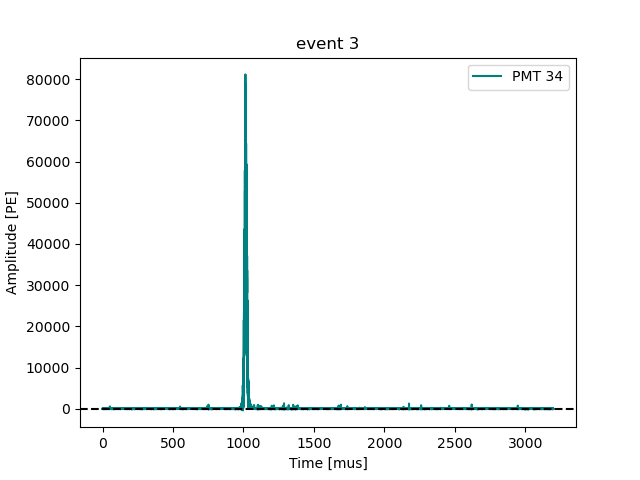

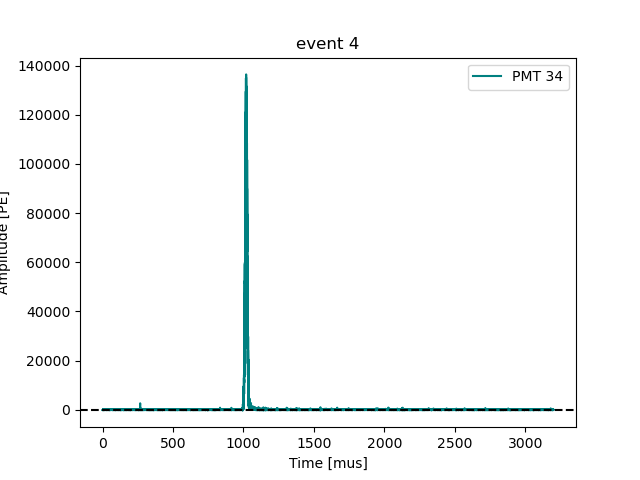

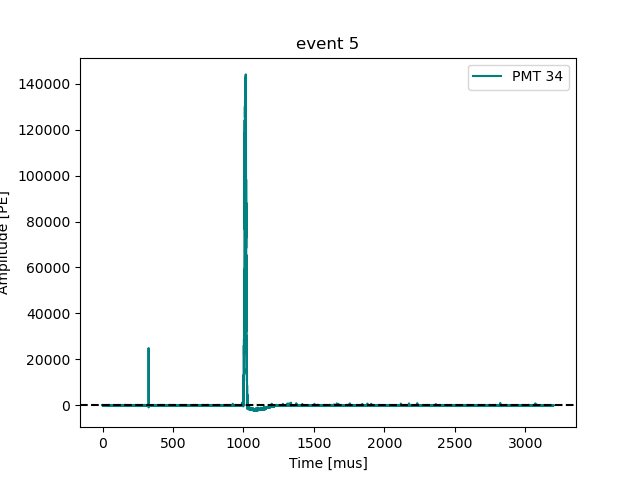

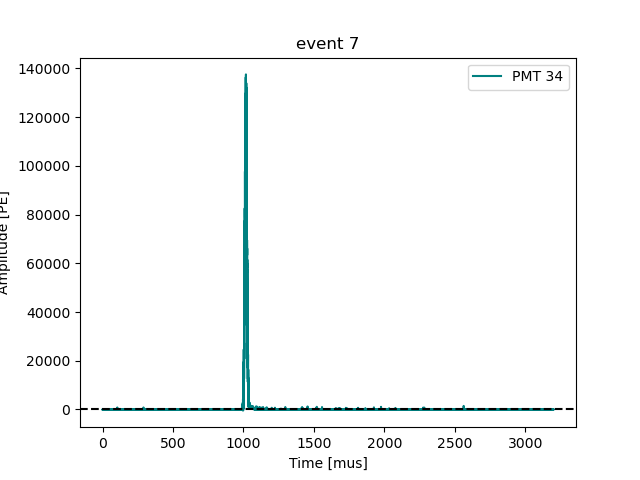

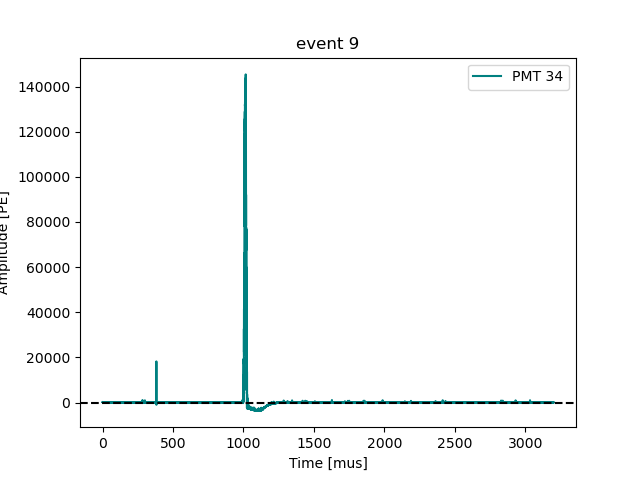

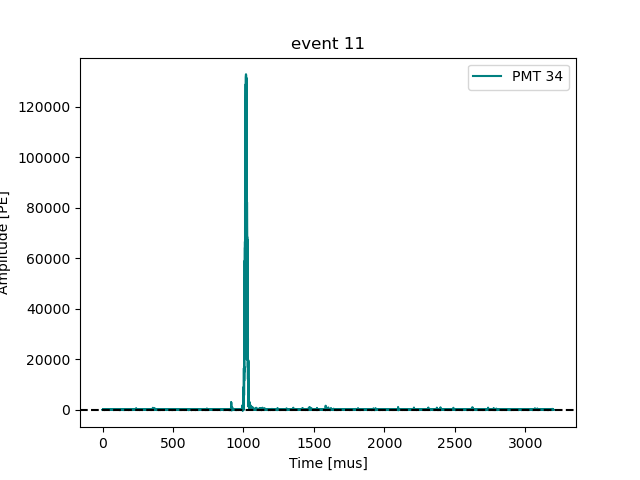

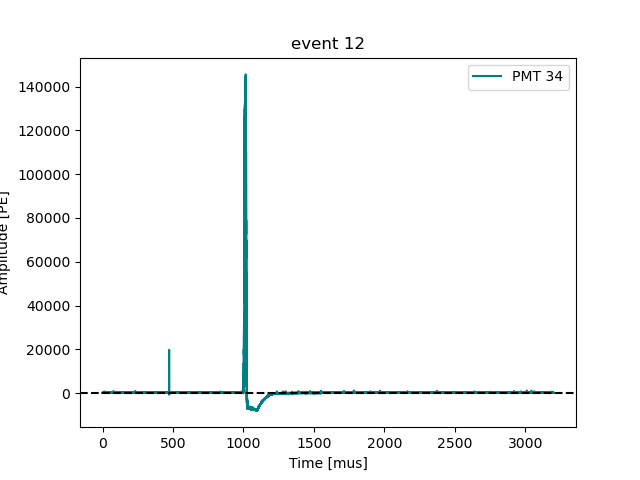

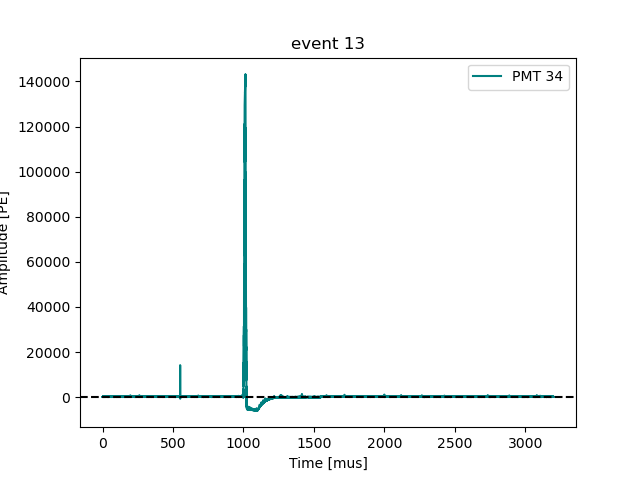

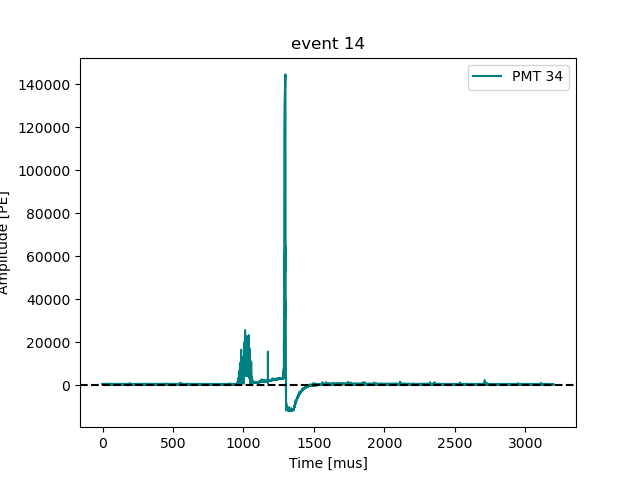

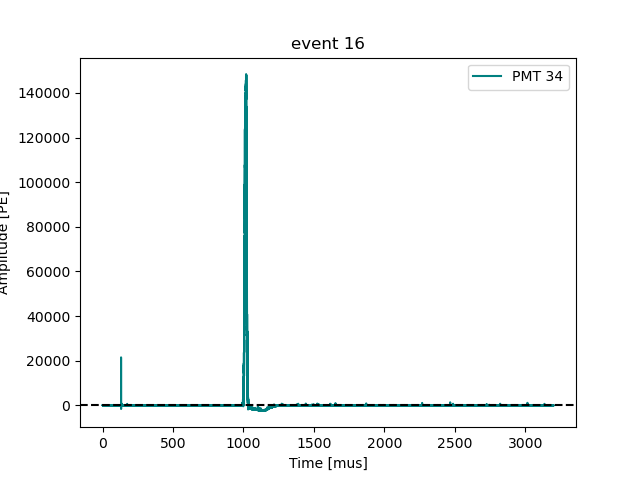

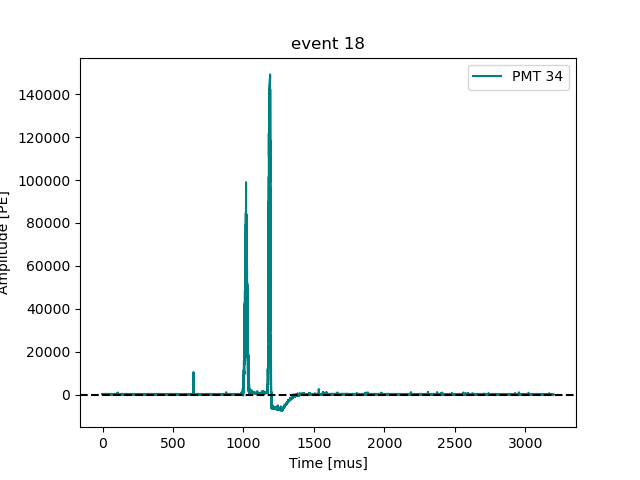

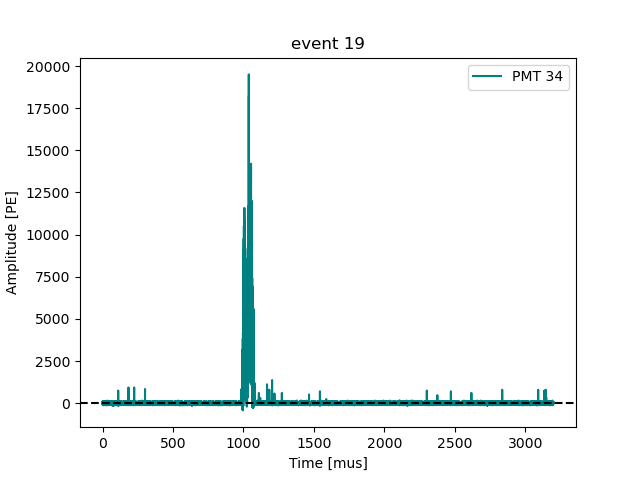

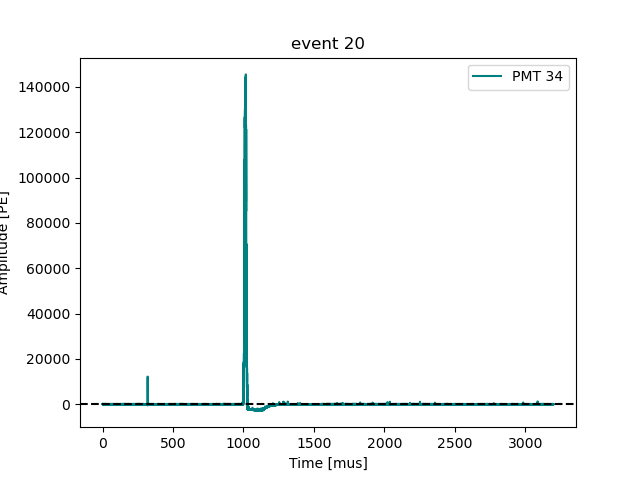

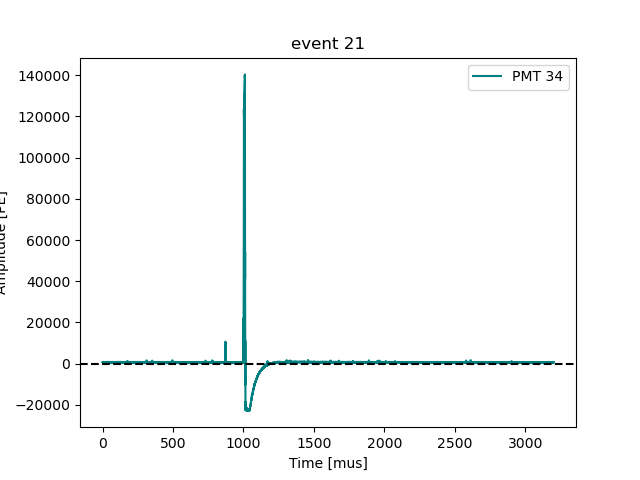

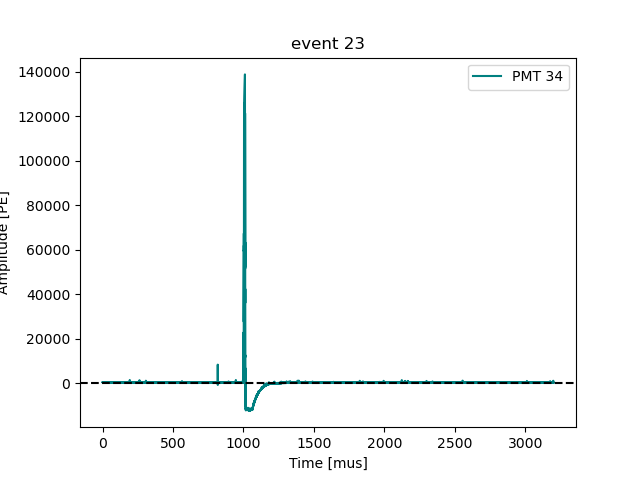

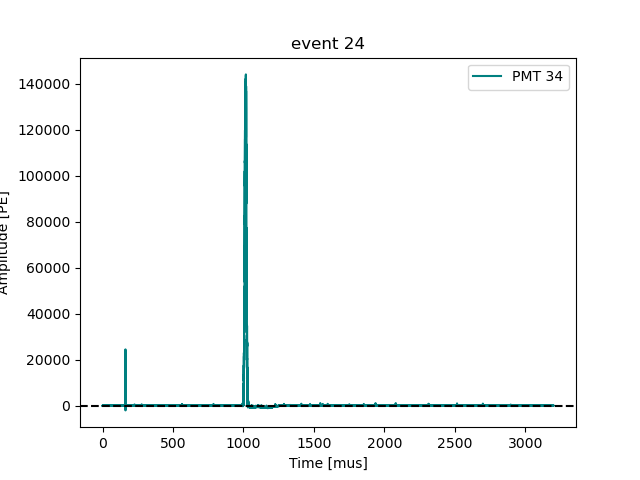

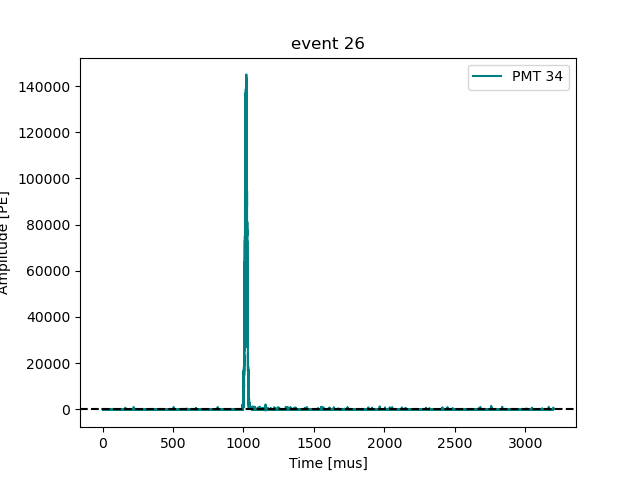

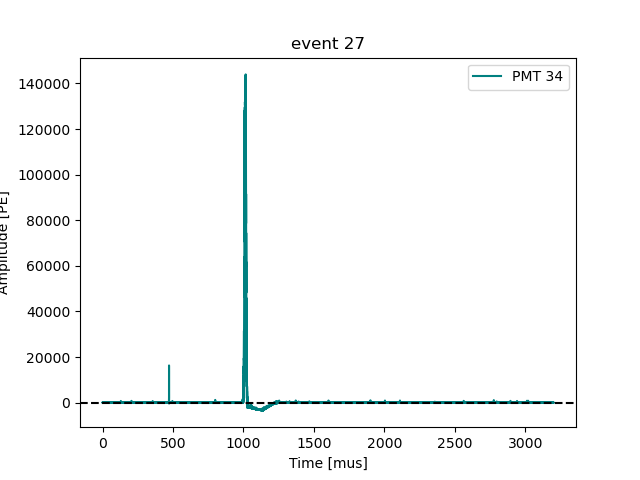

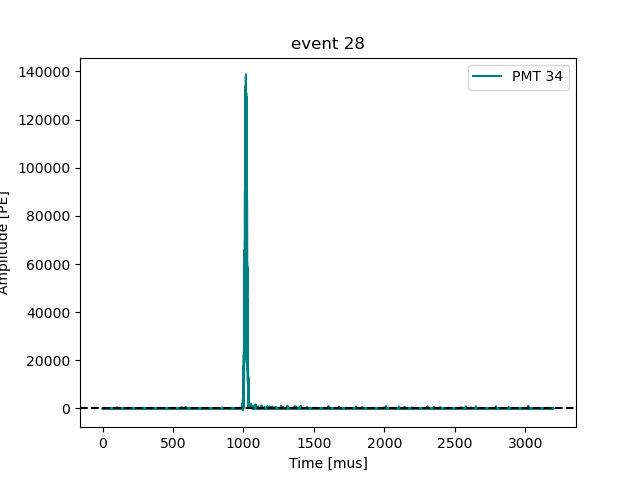

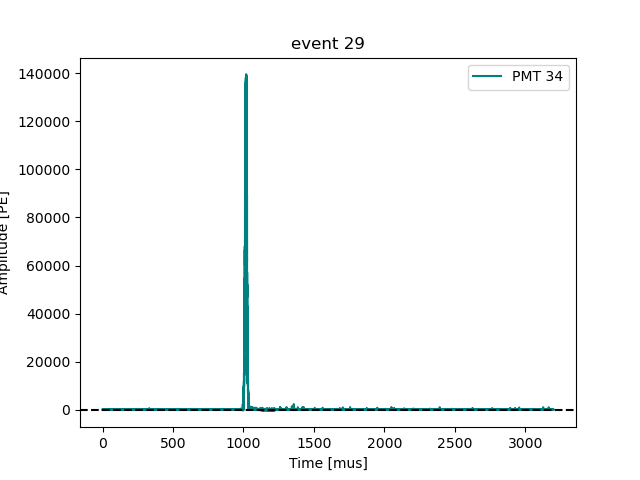

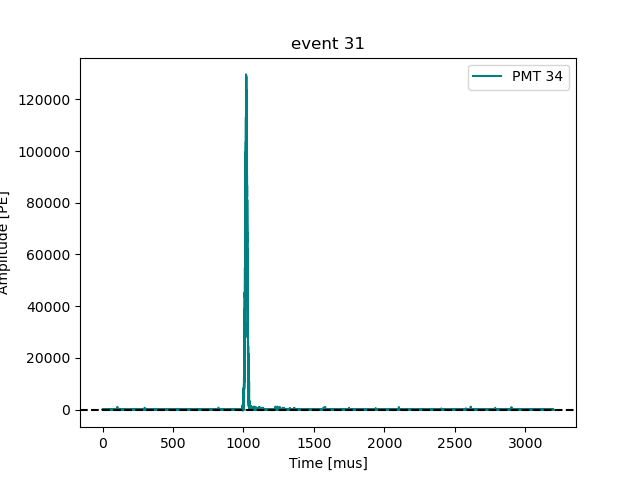

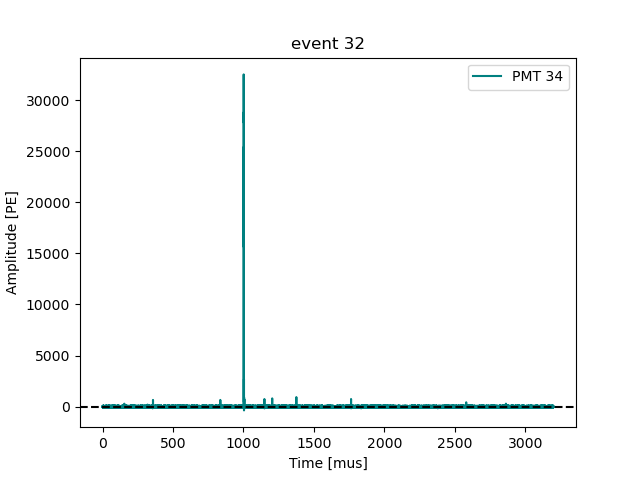

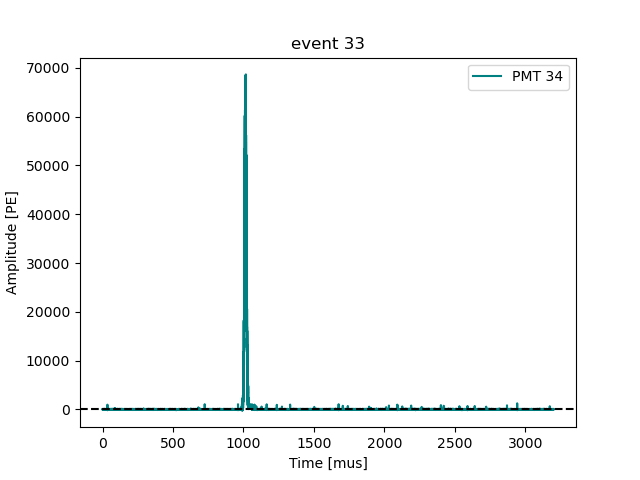

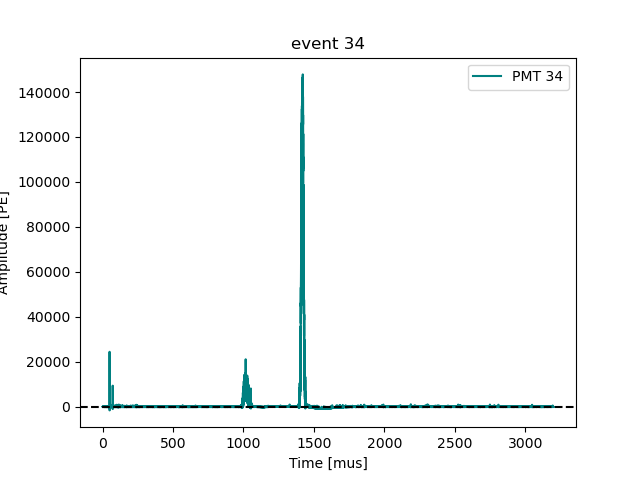

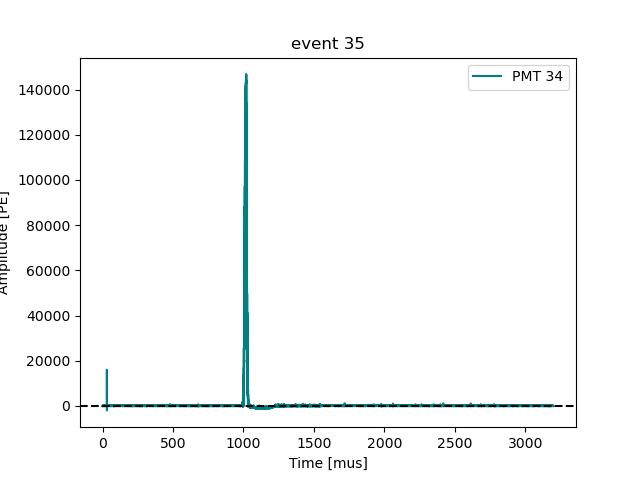

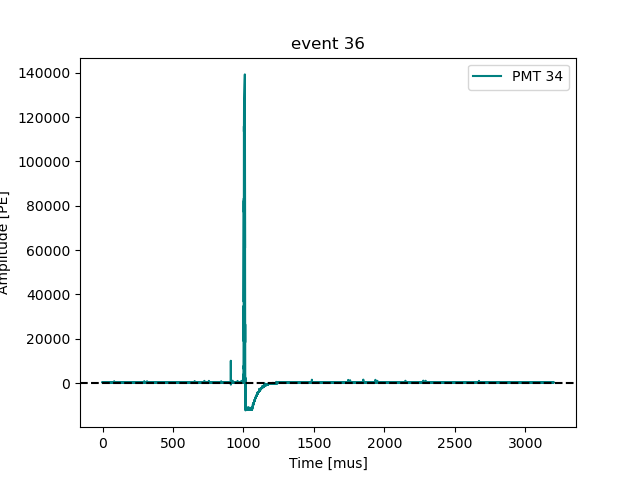

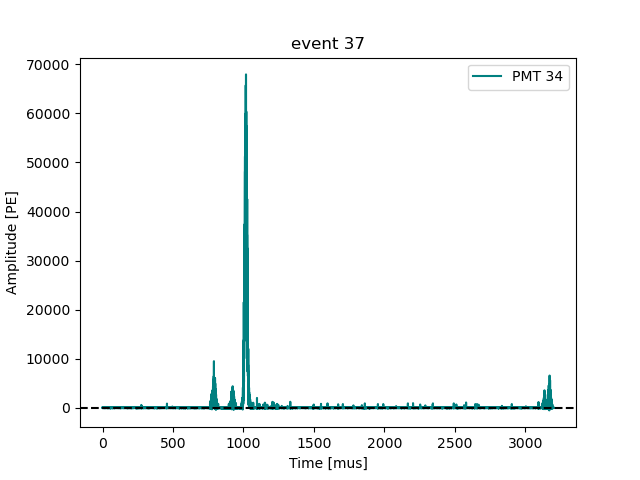

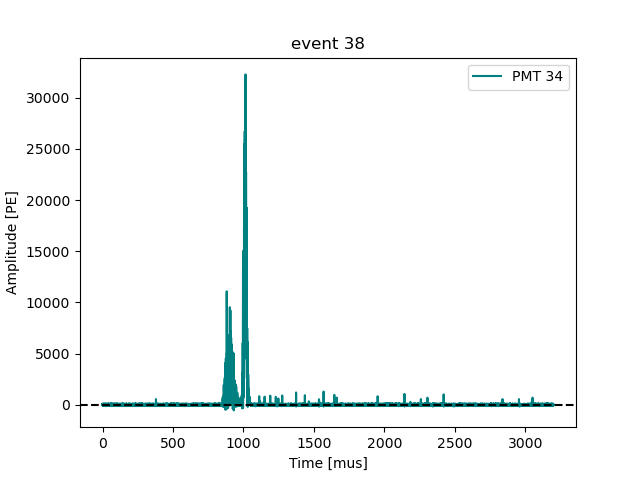

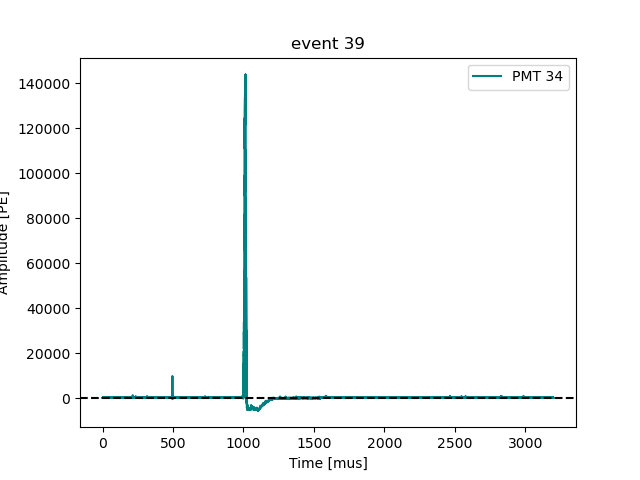

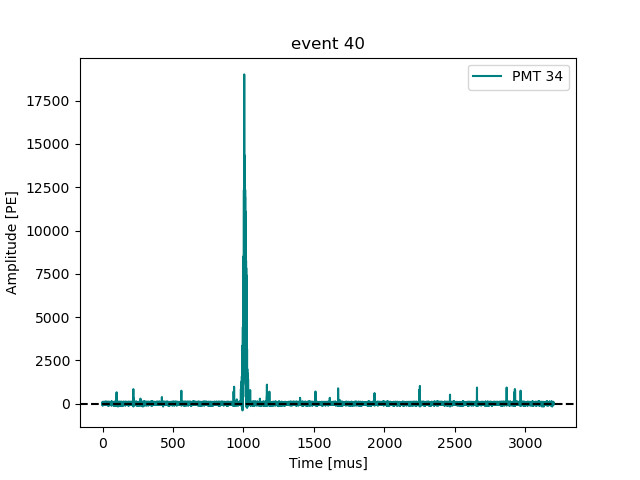

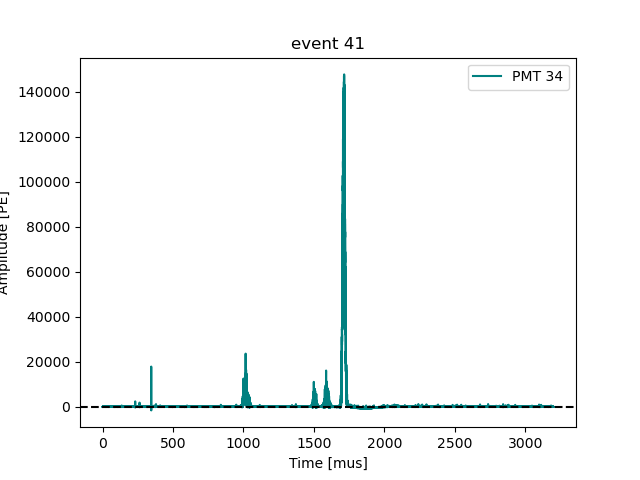

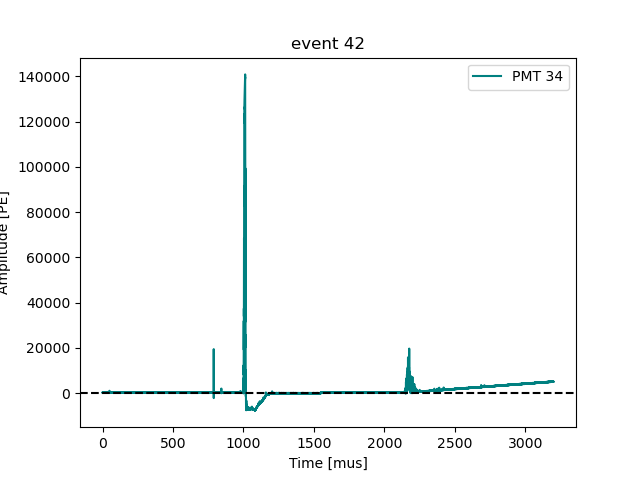

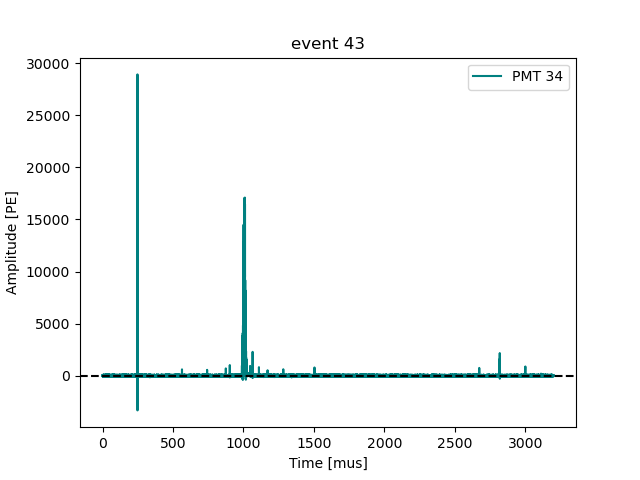

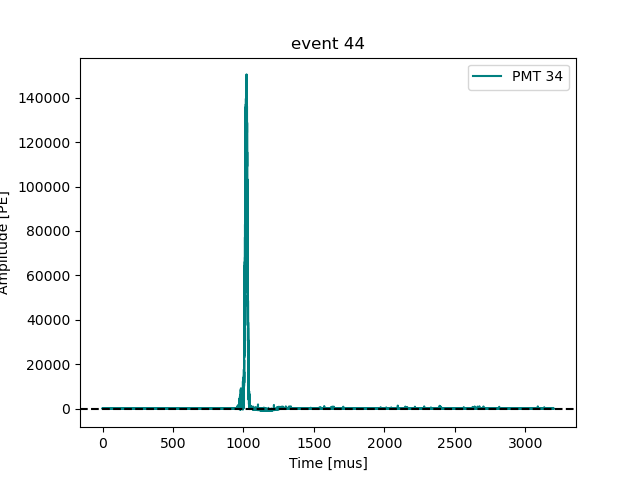

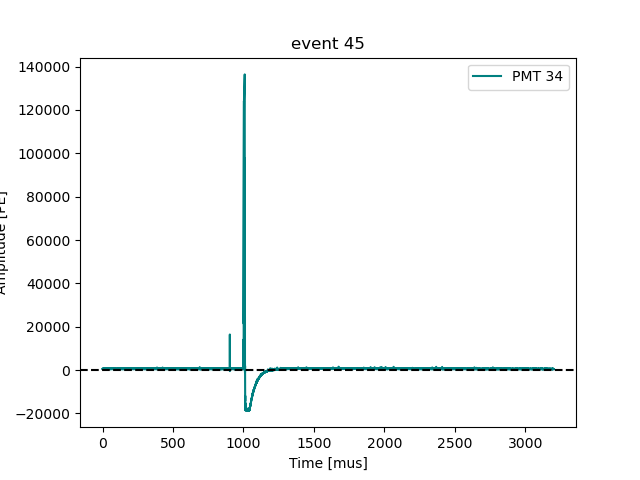

: 

In [38]:
%matplotlib widget
# good events: 4,5,  37
event_number = 6

wf_sum_all_evts = 0

# highest = highest PMT waveform, "summed" = summed waveform across all PMT, "1-60" select PMT number for a specific pmt
plot_mode = "highest"
# plot_mode = "summed"
# plot_mode = "0"

with tb.open_file(filename) as file:

    rwf      = file.root.RD.pmtrwf

    for evt_no, wfs in enumerate(rwf):

        print("On Event:", evt_no)
        
        # if (evt_no != event_number):
        #     continue

        if (evt_no > 45):
            break

        # if (evt_no in [3,6,7,9,14,17,20,22,23, 25,31,32,33,36,37,40,44,46]):
            # continue

        if (evt_no in [0,1,2,6,8,10,15,17,22,25,25,30]):
            continue

        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

        # Zero out the dead PMTs
        for pmt_ in dead_pmts:
            wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        
        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, event_number)

        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y
        print(x_pos, y_pos)

        sp_pmt  = 25e-3 # sampling period in mus
        sp_sipm = 1     # sampling period in mus
        times   = np.arange(wfs[0] .size) * sp_pmt
        t_sipm  = np.arange(highest_sipm.size) * sp_sipm

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        interps = GetBaselineInterp(noise, wfs, times)

        # Correct the waveforms
        wfs = CorrectDeconvBaseline(times, grass_lim[0], grass_lim[0]+500, interps, wfs) # Correct baseline 500 mus after the pulse

        # Choose which waveform to plot
        if (plot_mode == "highest"):
            index = np.argmax(np.max(wfs, axis=1))
            wf_pmt = wfs[index]
            plot_mode = index
        elif (plot_mode == "summed"):
            wf_pmt =  sum_wf(wfs)
        else:
            wf_pmt = wfs[int(plot_mode)]

        A, mu, sigma = FitS2(times[int(S2_start/tc):int(S2_end/tc)], wf_pmt[int(S2_start/tc):int(S2_end/tc)])
        area = A * sigma * np.sqrt(2 * np.pi)
        print(f"Area under the Gaussian: {area:.2f}")

        # new_time = np.linspace(1500,2000,500)
        new_time = np.linspace(900,1400,500)
        interpolated_amplitude = interps[0](new_time)

        plt.figure()
        plt.plot(times, wf_pmt , label = f"PMT {plot_mode}",  color = "Teal");
        plt.ylabel("Amplitude [PE]")
        plt.xlabel("Time [mus]")
        plt.axhline(y=0, color='black', linestyle='--')
        plt.legend(loc = "upper right")
        plt.title(f"event {evt_no}")

        # plt.plot(filtered_time, filtered_amplitude, 'o', label="Filtered Points", color="red")
        # plt.plot(filtered_time, smoothed_amplitude, label="Smoothed Line", color="blue")
        # plt.plot(new_time, interpolated_amplitude, label="Interpolation", color="red")
        
        # plt.plot(new_time, Gaussian(new_time, A,mu,sigma), color="red")

        

        peaks, _ = find_peaks(wf_pmt[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height = 2000, distance = 30/tc)

        pass_flag, grass_peaks = check_summed_baseline(wf_pmt, grass_lim, scale_factor)
        print(len(grass_peaks))

        # if (len(grass_peaks) > 0):
        #     plt.plot(times[grass_peaks+int(grass_lim[0]/25e-3)], wf_pmt[grass_peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')


        # Check the baseline, if we got something really negative
        # then the deconvolution likely failed, so skip grass calculation
        min_baseline = min(wf_pmt[int((grass_lim[0]-50)/tc):int((grass_lim[0]+100)/tc)])
        if (min_baseline > -2000):
            print("event passed min baseline", min_baseline)

        # plt.xlim(1020,1100)
        # plt.ylim(-100,200)
        # plt.semilogy()

        # plt.axvline(x=1050, color='black', linestyle='--')
        # plt.axvline(x=1770, color='black', linestyle='--')
        # plt.axvline(x=1785, color='blue', linestyle='--')
        # plt.axvline(x=1860, color='blue', linestyle='--')

        # if (len(grass_peaks) < 2 and min_baseline > -2000 and len(peaks) < 1):
        #     print("passed!\n")
        wf_sum_all_evts+=wf_pmt
        
        # plt.savefig(f"../plots/deconvolved/run_{RUN_NUMBER}_event{evt_no}.png")


[]

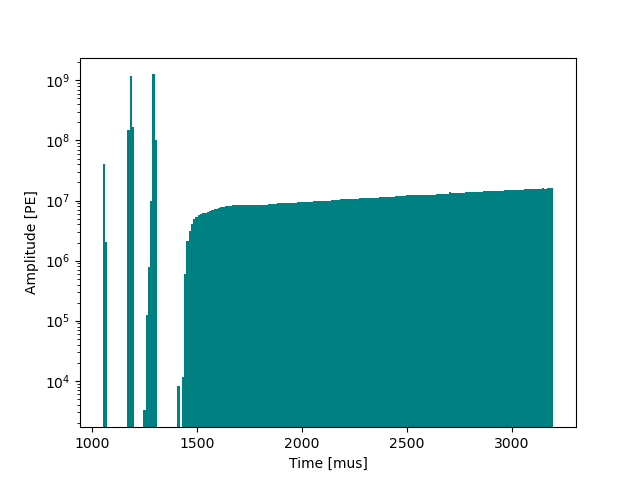

In [34]:
plt.figure()

# mask = wf_pmt > 0

# plt.hist(times[mask], weights = wf_pmt[mask], bins = np.linspace(2500,3200,500));
# plt.hist(times[mask], weights = wf_pmt[mask], bins = np.linspace(1500,2000,20), color="Teal");

mask = wf_sum_all_evts>0
# plt.hist(times[mask], weights = wf_sum_all_evts[mask], bins = np.linspace(1050,2000,200), color="Teal");
plt.hist(times[mask], weights = wf_sum_all_evts[mask], bins = np.linspace(1050,3200,200), color="Teal");
plt.ylabel("Amplitude [PE]")
plt.xlabel("Time [mus]")
plt.semilogy()

In [27]:


folder_out = Path("../data/analysis/")


wf_sum = 0
wf_sum_clean = 0

data = []
data_properties = []
with tb.open_file(filename) as file:
    file_no=0
    evt_info = file.root.Run.events
    rwf      = file.root.RD.pmtrwf
    time     = np.arange(rwf.shape[2]) * tc
    tsel     = in_range(time, *grass_lim)
    for evt_no, wfs in enumerate(rwf):

        print("On Event:", evt_no, "real ID:", evt_info[evt_no][0])

        # if (evt_no != 3):
        #     continue

        # if (evt_no > 1): continue

        highest_sipm = find_highest_sipm(file.root.RD.sipmrwf, evt_no)
        x_pos = datasipm.iloc[highest_sipm].X
        y_pos = datasipm.iloc[highest_sipm].Y

        _, ts = evt_info[evt_no]
        
        if ( useRaw):
            wfs = CorrectRawBaseline(wfs)
        else:
            wfs = deconv(wfs)

        # Convert the ADC to PE
        wfs = ADC_to_PE(wfs, datapmt)

       # Zero out the dead PMTs
        for pmt_ in dead_pmts:
            wfs[pmt_] = np.arange(wfs[pmt_] .size) * 0
        
        wfs_sum = sum_wf(wfs)

        times   = np.arange(wfs_sum .size) * tc # sampling period in mus

        S1, _ = find_peaks(wfs_sum[ int(S1_window[0]/tc):int(S1_window[1]/tc)], height=S1_height, distance=40/tc)
        S2, _ = find_peaks(wfs_sum[ int(S2_window[0]/tc):int(S2_window[1]/tc)], height=S2_height, distance=200/tc)

        if (len(S1) ==0):
            print("No S1!")

        if (len(S2) ==0):
            print("No S2!")

        if (len(S1) !=1 or len(S2)!=1 ):
            deltaT = -999
        else:
            deltaT = S2[0]*tc+S2_window[0] - (S1[0]*tc+S1_window[0])
            # print("Time difference between S1 and S2:", deltaT)

        # Calcilate the noise of the PMT
        noise = []
        for pmt_no, wf in enumerate(wfs):
            noise.append(noise_sigma*np.std(wf[int(noise_lim[0]/tc):int(noise_lim[1]/tc)]))

        interps = GetBaselineInterp(noise, wfs, times)

        # Correct the waveforms
        wfs = CorrectDeconvBaseline(times, grass_lim[0], grass_lim[0]+500, interps, wfs) # Correct baseline 500 mus after the pulse

        # wf_sum_clean+=wfs_sum

        wfs_sum_cor = sum_wf(wfs)
        wf_sum_clean+=wfs_sum_cor

        # Check if event failed the quality control, use corrected waveform
        pass_flag, grass_peaks = check_summed_baseline(wfs_sum_cor, grass_lim, scale_factor)
        if (pass_flag):
            print("Event Failed Quality Control...")
            continue

        print("Num Grass Peaks:", len(grass_peaks))

        
        peaks2, _ = find_peaks(wfs_sum[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=2000, width=0.5/tc)
        # if (len(grass_peaks) < 0 and len(peaks2) < 1):
        #     wfs_sum_cor = sum_wf(wfs)
        #     wf_sum_clean+=wfs_sum_cor


        # Sum values in the peak up to the point where the pulse goes to zero
        S2_area = wfs_sum[int(S2_start/tc):int(S2_end/tc)]
        S2_area = S2_area[S2_area > 0].sum()*tc

        FWHM, S2_amplitude = find_fwhm(times[int(S2_start/tc):int(S2_end/tc)], wfs_sum[int(S2_start/tc):int(S2_end/tc)])
        A, mu, sigma = FitS2(times[int(S2_start/tc):int(S2_end/tc)], wfs_sum[int(S2_start/tc):int(S2_end/tc)])
        area = A * sigma * np.sqrt(2 * np.pi)

        print("S2 times are:", mu, S2[0]*tc+S2_window[0])
        print("Sigma is: ", FWHM/2.355, sigma)

        cath_df = get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, cath_lim)
        cath_df = pd.concat(cath_df, ignore_index=True)
        # display(cath_df[cath_df.pmt == 1])
        cath_area = cath_df.pe_int.sum()*tc
        cath_time = cath_df.peak_time.mean()
        cath_std = cath_df.peak_time.std()
        
        data_properties.append(pd.DataFrame(dict(event = evt_info[evt_no][0], S2_area=S2_area, S2_areafit=area,S2_time = mu, cath_area=cath_area,cath_time=cath_time,cath_std=cath_std, ts_raw=ts/1e3, deltaT=deltaT, sigma = FWHM/2.355, x = x_pos, y = y_pos, grass_peaks = len(grass_peaks), nS1 = len(S1)), index=[0]))

        # Check the baseline, if we got something really negative
        # then the deconvolution likely failed, so skip grass calculation
        min_baseline = min(wfs_sum_cor[int((grass_lim[0]-50)/tc):int((grass_lim[0]+100)/tc)])
        if (min_baseline > -2000):
            df = get_PEs_inWindow(times, wfs, noise, thr_split, peak_minlen, peak_maxlen, half_window, grass_lim)
            data = data + df
        else:
            print("Problem with deconvolution", min_baseline)

    data = pd.concat(data, ignore_index=True)
    data = data.assign(ts = np.array(list(map(datetime.fromtimestamp, data.ts_raw))))
    # data.to_hdf(file_out, "/data", complib="zlib", complevel=4, mode="w")

    data_properties = pd.concat(data_properties, ignore_index=True)
    data_properties = data_properties.assign(ts = np.array(list(map(datetime.fromtimestamp, data_properties.ts_raw))))



On Event: 0 real ID: 2
216
No S2!
Num Grass Peaks: 0
1413.4910535134952 1620.6 15.66792730914467


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
display(data)
display(data_properties)

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,4550,1.730123e+09,0,43.268325,1656.350,121.339707,2024-10-28 08:47:33.196
1,4550,1.730123e+09,0,58.153331,1698.325,121.339707,2024-10-28 08:47:33.196
2,4550,1.730123e+09,0,20.012678,1792.500,121.339707,2024-10-28 08:47:33.196
3,4550,1.730123e+09,0,61.944758,2125.500,121.339707,2024-10-28 08:47:33.196
4,4550,1.730123e+09,0,58.813426,2197.250,121.339707,2024-10-28 08:47:33.196
...,...,...,...,...,...,...,...
5886,4613,1.730123e+09,59,28.752172,1951.650,105.221824,2024-10-28 08:47:35.396
5887,4613,1.730123e+09,59,22.544927,1987.375,105.221824,2024-10-28 08:47:35.396
5888,4613,1.730123e+09,59,36.248039,2034.600,105.221824,2024-10-28 08:47:35.396
5889,4613,1.730123e+09,59,29.853902,2148.350,105.221824,2024-10-28 08:47:35.396


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,ts
0,4550,1.617497e+07,1.596093e+07,1610.971473,5.784707,2523.045000,19.589956,1.730123e+09,700.525,4.687049,-96.875,-294.325,0,1,2024-10-28 08:47:33.196
1,4557,1.688356e+07,1.658009e+07,1608.757118,2.332824,2514.750000,6.540738,1.730123e+09,361.275,3.422515,335.525,60.825,0,1,2024-10-28 08:47:33.375
2,4564,1.950986e+07,1.932770e+07,1610.345817,0.678913,2527.035000,13.096592,1.730123e+09,392.625,3.895117,-126.975,-63.075,0,1,2024-10-28 08:47:33.626
3,4571,1.380819e+07,1.385034e+07,1613.989339,15.733348,2520.665476,12.007806,1.730123e+09,1234.300,6.169131,104.275,414.975,0,1,2024-10-28 08:47:33.869
4,4578,1.610120e+07,1.608076e+07,1609.430319,18.523113,2525.200000,16.201111,1.730123e+09,329.675,3.187170,-96.875,-294.325,0,1,2024-10-28 08:47:34.080
5,4585,1.695163e+07,1.693714e+07,1614.261613,9.340787,2526.747222,11.383688,1.730123e+09,-999.000,6.109916,319.975,-171.425,1,2,2024-10-28 08:47:34.249
6,4592,6.443190e+06,6.347572e+06,1612.082669,6.052088,2531.772917,14.646309,1.730123e+09,1327.675,6.105679,427.825,106.475,0,1,2024-10-28 08:47:34.634
7,4599,1.779115e+07,1.762947e+07,1614.701846,24.112584,2527.790179,11.921631,1.730123e+09,1217.325,6.226626,304.425,214.325,0,1,2024-10-28 08:47:34.839
8,4606,1.704391e+07,1.694136e+07,1608.386066,22.186079,2524.790909,10.569333,1.730123e+09,-999.000,2.906512,165.475,276.025,1,2,2024-10-28 08:47:35.090
9,4613,1.655112e+07,1.640144e+07,1613.290284,13.452537,2512.004412,8.729880,1.730123e+09,1126.375,5.789663,-281.475,184.225,0,1,2024-10-28 08:47:35.396


: 

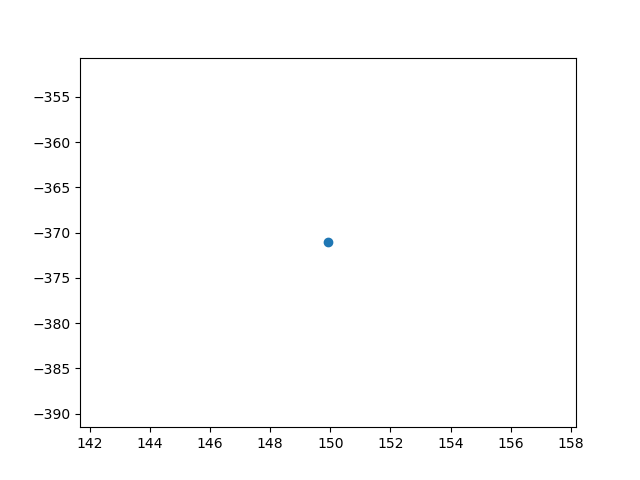

In [ ]:
plt.figure()

plt.scatter(data_properties.x, data_properties.y)

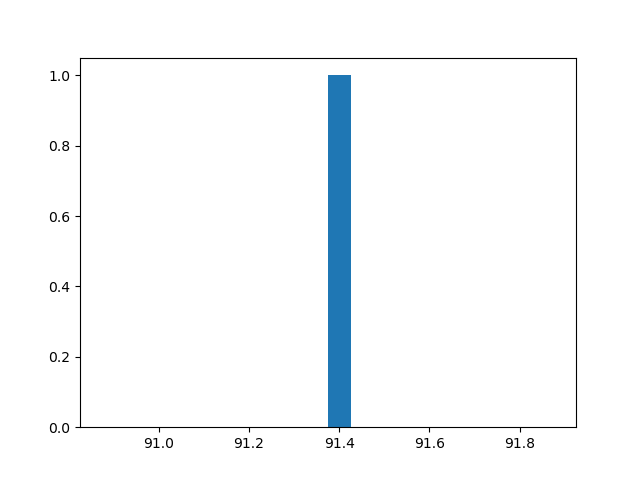

In [ ]:
plt.figure()
plt.hist(data_properties.deltaT, bins = 20);

,event,S2_area,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,x,y,grass_peaks,nS1,ts


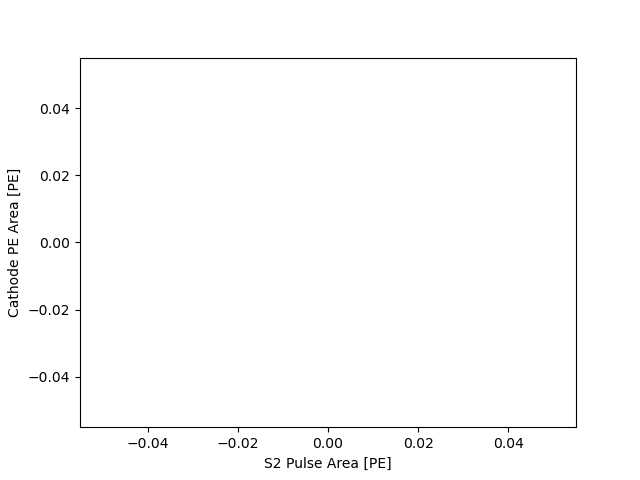

In [ ]:
plt.figure()

prop_filt = data_properties[data_properties.grass_peaks == 0]

plt.scatter(prop_filt.S2_area, prop_filt.cath_area)
plt.xlabel("S2 Pulse Area [PE]")
plt.ylabel("Cathode PE Area [PE]")

display(data_properties[data_properties.cath_area > 1.25e7])

AttributeError: 'int' object has no attribute 'size'

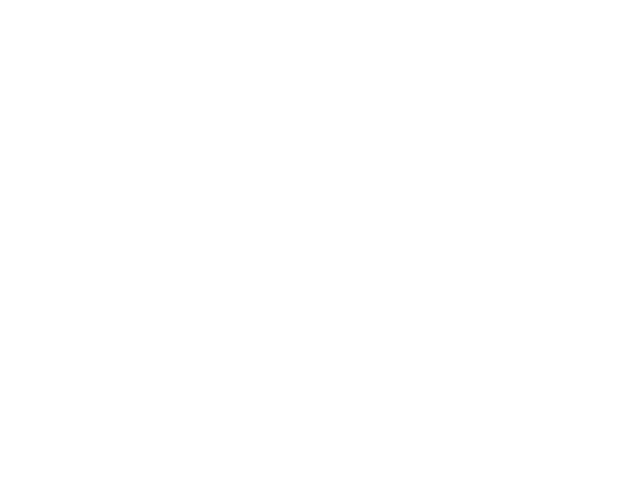

In [ ]:
plt.figure()
t_pmt   = np.arange(wf_sum_clean .size) * 25e-3 # sampling period in mus
plt.plot(t_pmt , wf_sum_clean, label = "PMT SUM", color = "Teal");

# peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=noise[6], distance=0.3/tc)
peaks, _ = find_peaks(wf_sum_clean[ int(grass_lim[0]/tc):int(grass_lim[1]/tc)], height=3000, width=0.5/tc)
print(peaks*tc+grass_lim[0])

# peaks, _ = find_peaks(wf_sum_clean[ int(100/tc):int(985/tc)], height=10000, distance=40/tc)
# print(peaks*tc+100)

# peaks, _ = find_peaks(wf_sum_15[ int(grass_lim[0]/25e-3):int(grass_lim[1]/25e-3)], height=noise[15], distance=1/25e-3)


plt.plot(t_pmt[peaks+int(grass_lim[0]/25e-3)], wf_sum_clean[peaks+int(grass_lim[0]/25e-3)], 'x', label='Peaks')

# plt.axhline(y=0, color='black', linestyle='--')

# plt.semilogy()
plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [PE]")

# plt.xlim(1300, 1900)
# plt.ylim(-100, 1000)

plt.legend()
plt.tight_layout()

plt.axhline(y=0, color='black', linestyle='--')

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,27760,1.723015e+09,0,2182.857232,1051.200,109.848374,2024-08-07 02:12:55.076
1,27760,1.723015e+09,0,1874.460634,1052.475,109.848374,2024-08-07 02:12:55.076
2,27760,1.723015e+09,0,1719.989659,1053.025,109.848374,2024-08-07 02:12:55.076
3,27760,1.723015e+09,0,1894.644260,1053.425,109.848374,2024-08-07 02:12:55.076
4,27760,1.723015e+09,0,598.546350,1053.925,109.848374,2024-08-07 02:12:55.076
...,...,...,...,...,...,...,...
3377,27760,1.723015e+09,59,1635.594300,1377.750,121.982845,2024-08-07 02:12:55.076
3378,27760,1.723015e+09,59,1133.069095,1498.450,121.982845,2024-08-07 02:12:55.076
3379,27760,1.723015e+09,59,1105.853509,1552.625,121.982845,2024-08-07 02:12:55.076
3380,27760,1.723015e+09,59,1140.208114,1602.500,121.982845,2024-08-07 02:12:55.076


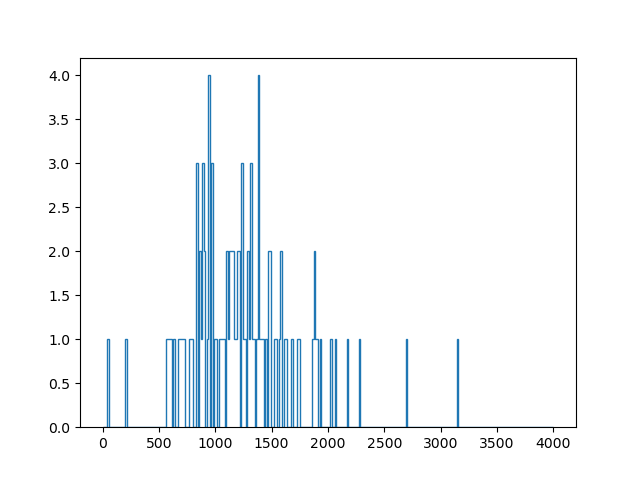

In [ ]:
display(data)
plt.figure()
# for pmt in data.pmt.unique():
    # if (pmt <= 50 and pmt >= 49):
    # plt.hist(data[data.pmt == pmt].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = pmt);


# plt.hist(data[data.pmt == 0].pe_int, bins = np.arange(0, 300, 1), histtype = "step",  label = "PMT 12");
plt.hist(data[data.pmt == 1].pe_int, bins = np.linspace(0, 4000, 300), histtype = "step",  label = "PMT 13");
# plt.hist(data[data.pmt == 2].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 14");
# plt.hist(data[data.pmt == 3].pe_int, bins = np.arange(0, 300, 1), histtype = "step", label = "PMT 15");
# plt.hist(data[data.pmt == 4].pe_int, bins = np.arange(0, 300, 1), histtype = "step");
# plt.hist(data[data.pmt == 10].pe_int, bins = np.arange(0, 300, 2), histtype = "step");




# plt.legend()

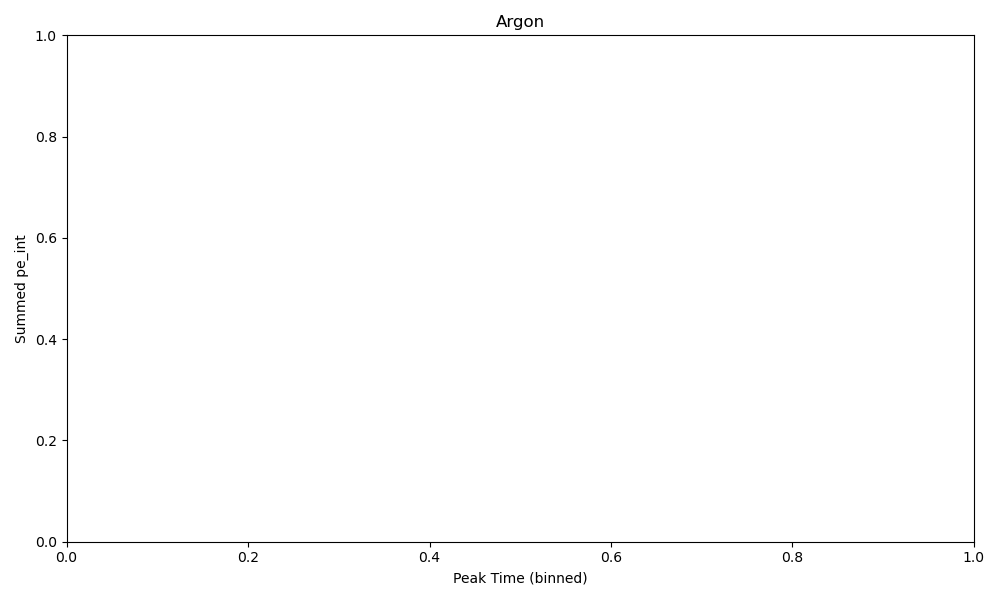

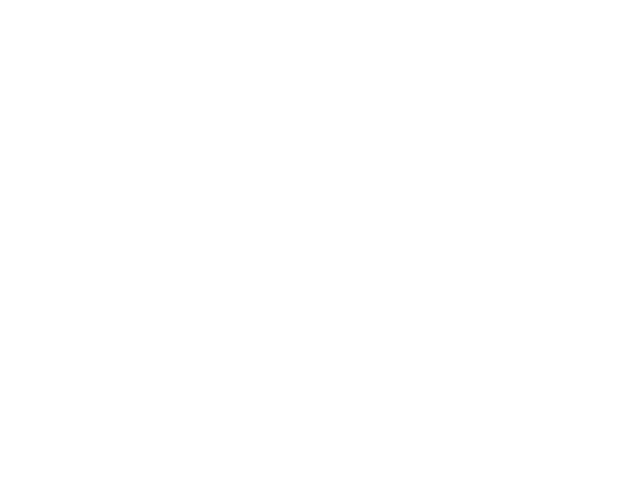

In [ ]:
# Plot the PE charge vs time in the window
plt.figure()

# 1. Group by 'event' and sum 'pe_int' for each event
# summed_pe_int = data.groupby('event')['pe_int'].sum()

# 1. Define bins for peak_time from 1350 to 1770 in steps of 10
bins = np.arange(grass_lim[0], grass_lim[1], 50)  # Bins from 1350 to 1770 with step of 10
data['peak_time_bin'] = pd.cut(data['peak_time'], bins, include_lowest=True, labels=bins[:-1])

# 2. Group by 'event' and 'peak_time_bin', then sum 'pe_int'
grouped = data.groupby(['event', 'peak_time_bin'])['pe_int'].sum().reset_index()

# 3. Plot each event as a separate curve
plt.figure(figsize=(10, 6))

for index, event in enumerate(grouped['event'].unique()):
    event_data = grouped[grouped['event'] == event]
    S2_pulse = data_properties[data_properties['event'] == event]


    # if (index >10):
    #     continue

    if (S2_pulse.grass_peaks.iloc[0]>0):
        continue

    print(event, event_data['pe_int'].astype(float).sum()/1e6)

    plt.plot(event_data['peak_time_bin'].astype(float)-1000, event_data['pe_int'], marker='o', linestyle='-', label=f'Event {event}')
    # plt.plot(event_data['peak_time_bin'], event_data['pe_int']/S2_pulse.S2_area.item(), marker='o', linestyle='-', label=f'Event {event}')

# 4. Customize plot
plt.xlabel('Peak Time (binned)')
plt.ylabel('Summed pe_int')
plt.title('Argon')
# plt.xticks(bins, rotation=45)
# plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()



